# Notebook to run basic QC on raw data before cellbender


**Created by :** Srivalli Kolla

**Created on :** 09 September, 2024

**Modified on :** 09 September, 2024

**Institute of SystemsImmunology, University of Würuburg**

## Load required modules

In [1]:
import anndata
import logging
import os
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import time
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad as median_abs_deviation
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')
timestamp = time.strftime("%d_%m_%Y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
asttokens           NA
attr                23.2.0
cffi                1.16.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
defusedxml          0.7.1
distutils           3.12.4
django              5.0.6
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.5
ipython_genutils    0.2.0
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
louvain             0.8.2
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.10.1
numpy               1.26.4
packaging           24.1
pandas              2.2.2
parso               0.8.4
patsy  

## Read `anndata` objects

In [3]:
files = [
    ("A9_2.h5ad"),
    ("A10_2.h5ad"),
    ("A11_2.h5ad"),
    ("A12_2.h5ad"),
    ("B1_2.h5ad"),
    ("B2_2.h5ad")
]

genotype_mapping = {
    "A9_2": "WT",
    "A10_2": "WT",
    "A11_2": "Mdx",
    "A12_2": "Mdx",
    "B1_2": "MdxSCID",
    "B2_2": "MdxSCID"
}

base_dir = '../../raw_data/raw_anndatas/'
before_cb_raw_samples_list = []

for filename in files:
    file_path = os.path.join(base_dir, filename)
    before_cb_raw_samples = sc.read(file_path)

    sample_name = os.path.splitext(filename)[0]
    before_cb_raw_samples.obs['sample'] = sample_name

    genotype = genotype_mapping[sample_name]
    before_cb_raw_samples.obs['genotype'] = genotype

    before_cb_raw_samples_list.append(before_cb_raw_samples)

before_cb_raw = ad.concat(before_cb_raw_samples_list, join='inner', keys=files)
before_cb_raw

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype'

In [4]:
before_cb_raw.write_h5ad(f'../../raw_data/raw_anndatas/dmd_merged_raw_before_cb_{timestamp}.h5ad')

In [5]:
adata = sc.read_h5ad('../../raw_data/raw_anndatas/dmd_merged_raw_before_cb_09_09_24.h5ad')
adata

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype'

## Compute QC stats

### Labelling Mt and Ribo genes

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') 
adata.var['ribo'] = adata.var_names.str.startswith(("rps","rpl"))
adata.var

,mt,ribo
Xkr4,False,False
Gm1992,False,False
Gm19938,False,False
Gm37381,False,False
Rp1,False,False
...,...,...
AC124606.1,False,False
AC133095.2,False,False
AC133095.1,False,False
AC234645.1,False,False


In [7]:
ribo_counts = adata.var['ribo'].value_counts()

mt_counts = adata.var['mt'].value_counts()

print("Counts of Ribosomal (ribo) Genes:")
print("False:", ribo_counts.get(False, 0))
print("True:", ribo_counts.get(True, 0))
print("\nCounts of Mitochondrial (mt) Genes:")
print("False:", mt_counts.get(False, 0))
print("True:", mt_counts.get(True, 0))

Counts of Ribosomal (ribo) Genes:
False: 32285
True: 0

Counts of Mitochondrial (mt) Genes:
False: 32272
True: 13


### Calculating QC metrics per cell

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [9]:
adata

AnnData object with n_obs × n_vars = 10055673 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualization of qc metrics

Text(0.5, 1.0, 'Mt and Ribo percentages - Before filtering')

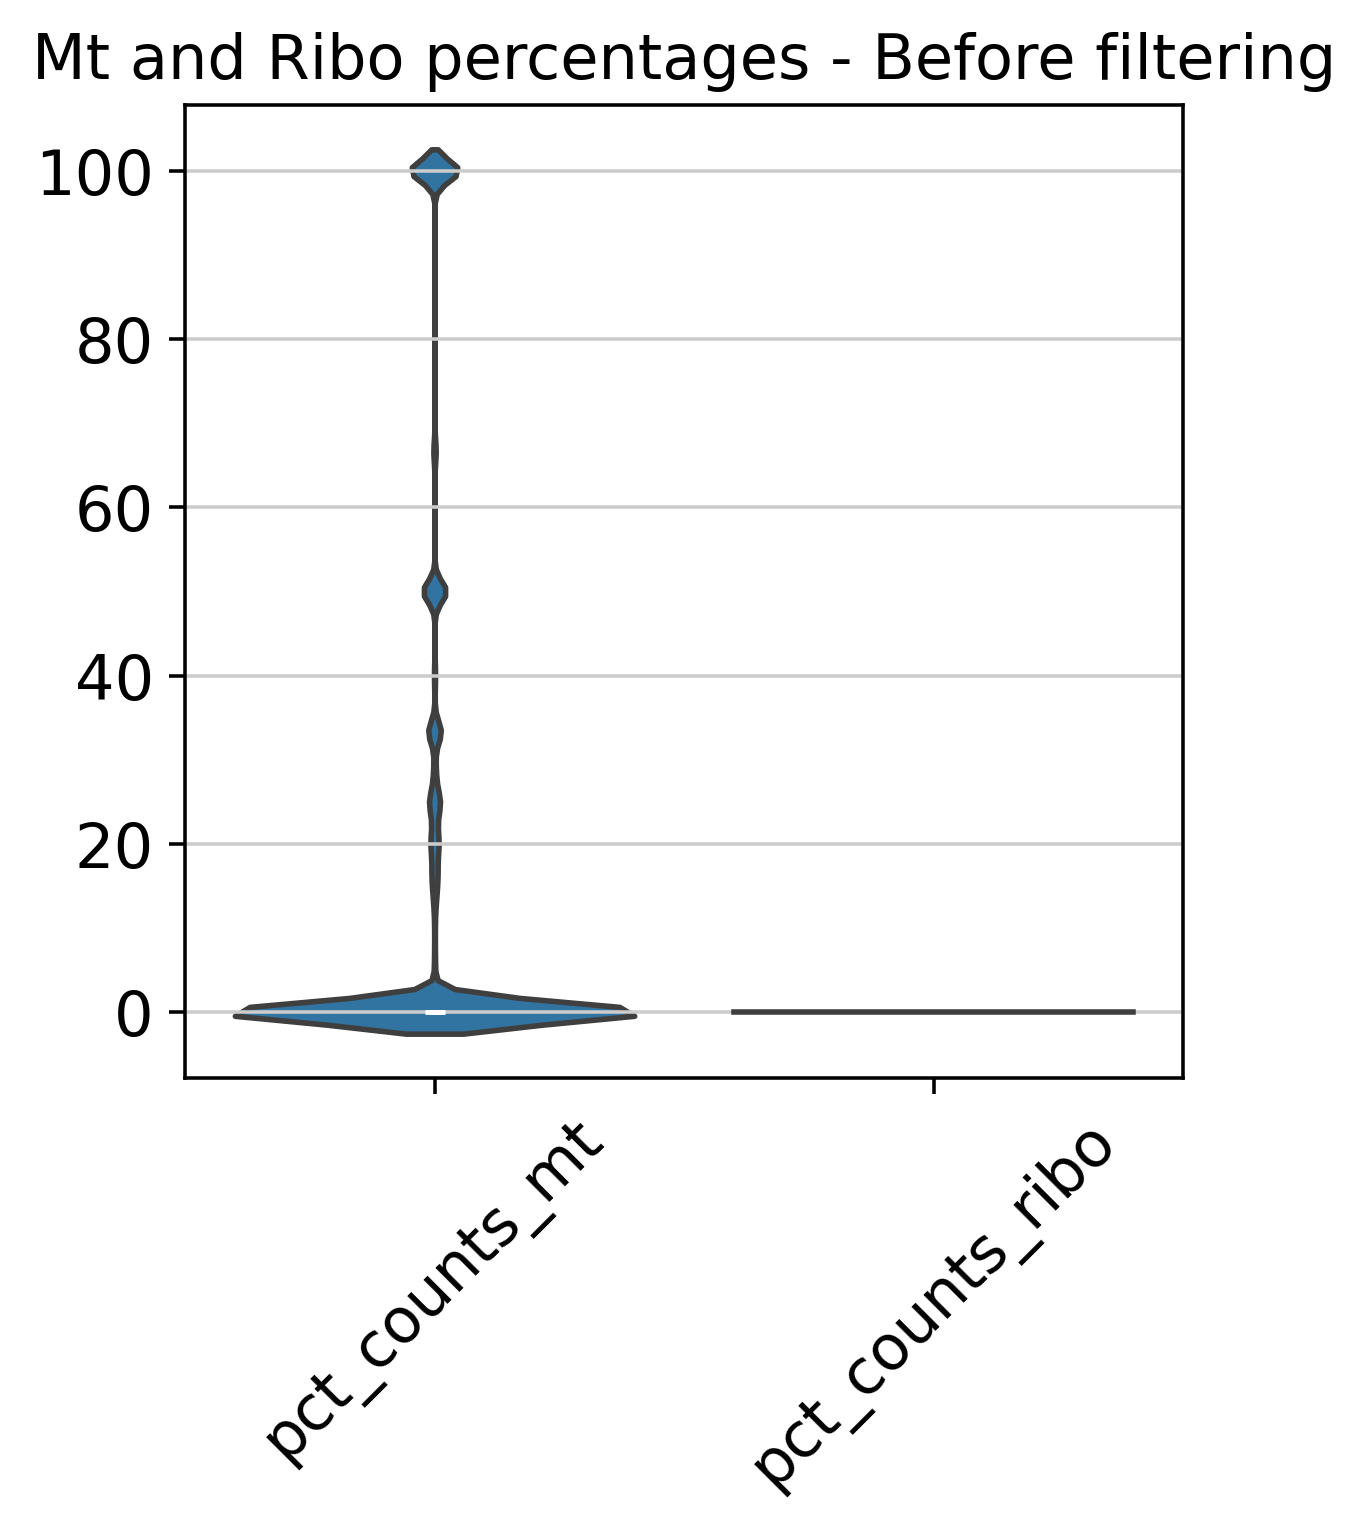

In [10]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sb.violinplot(data=adata.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - Before filtering')

##### *Description of violin plots*

**Violin Body**: The central part of the violin plot represents the probability density of the data.

**Box Plot**:
        Median (White line inside the box) Q2 ;
        Quartiles (the edges of the box) Q1,Q3 - Height of box represent Interquartile region (Q1-Q2-Q3) ;
        Outliers (points beyond the whiskers)

**Whiskers**: The whiskers extend from the box to the minimum and maximum values within 1.5 times the IQR from the first and third quartiles

**Outliers**: Individual data points beyond the whiskers

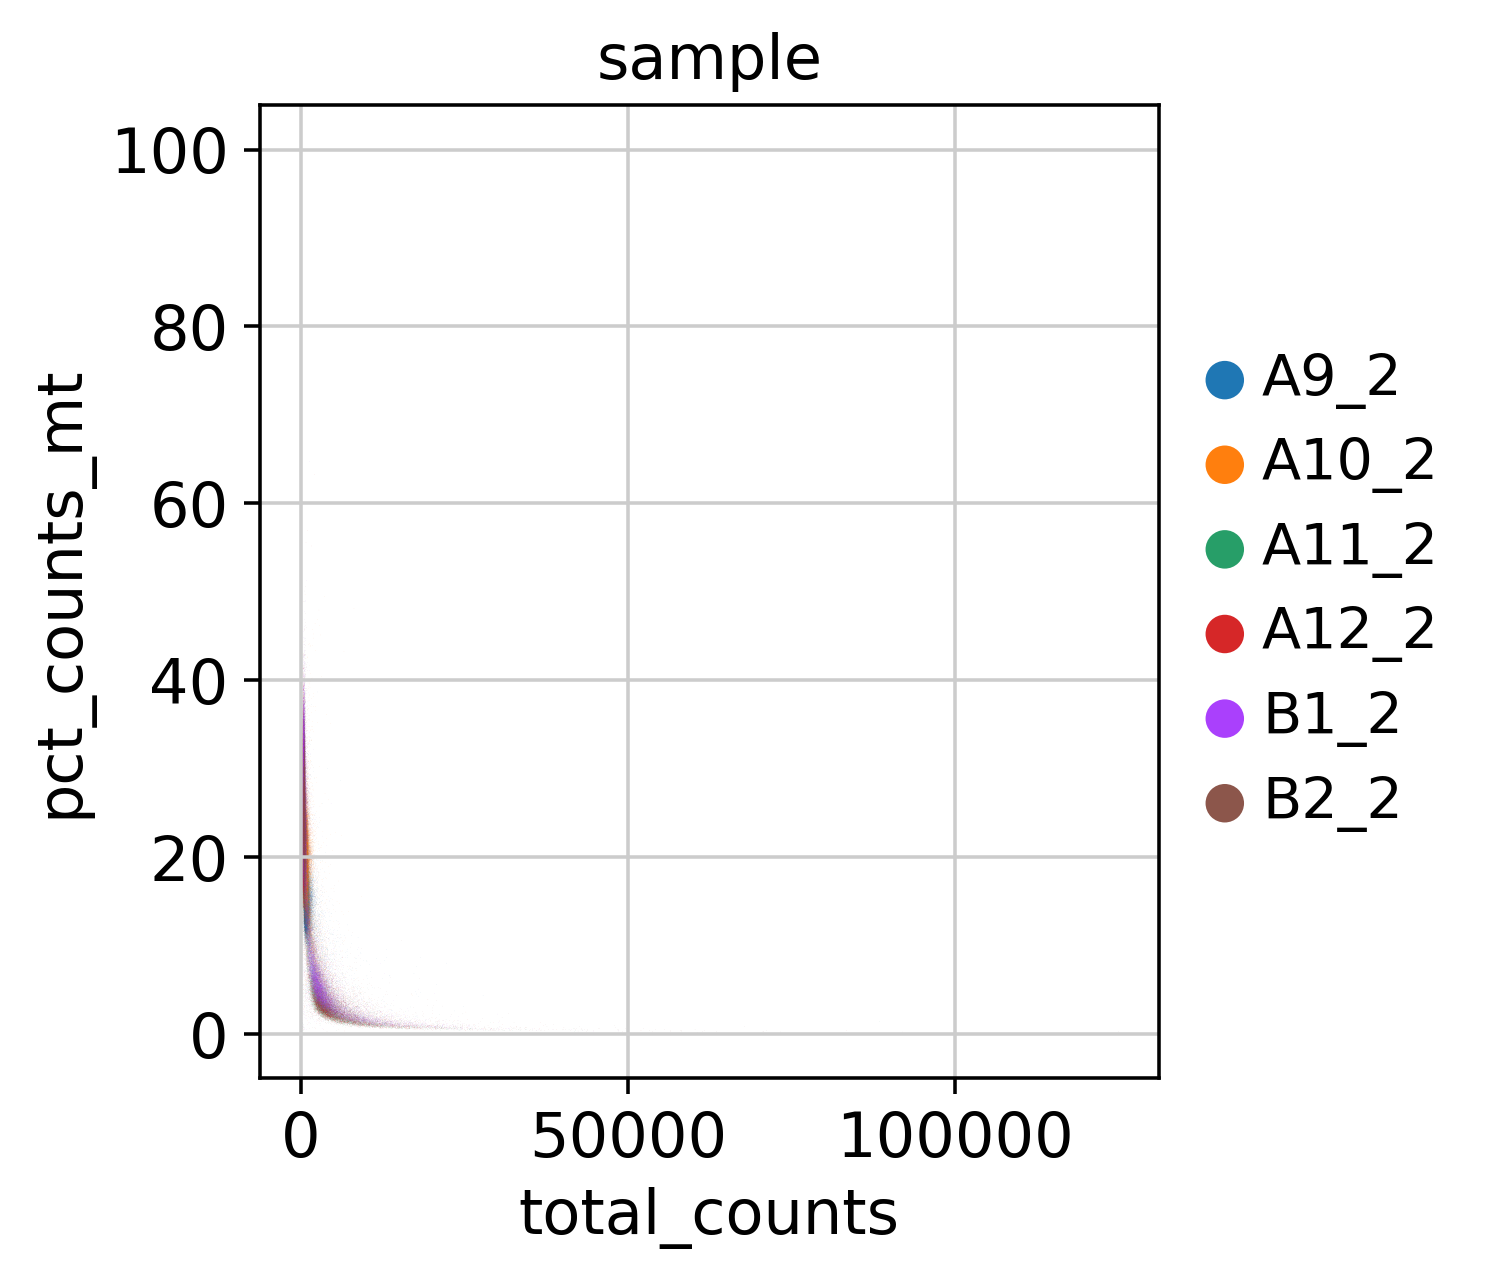

In [11]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

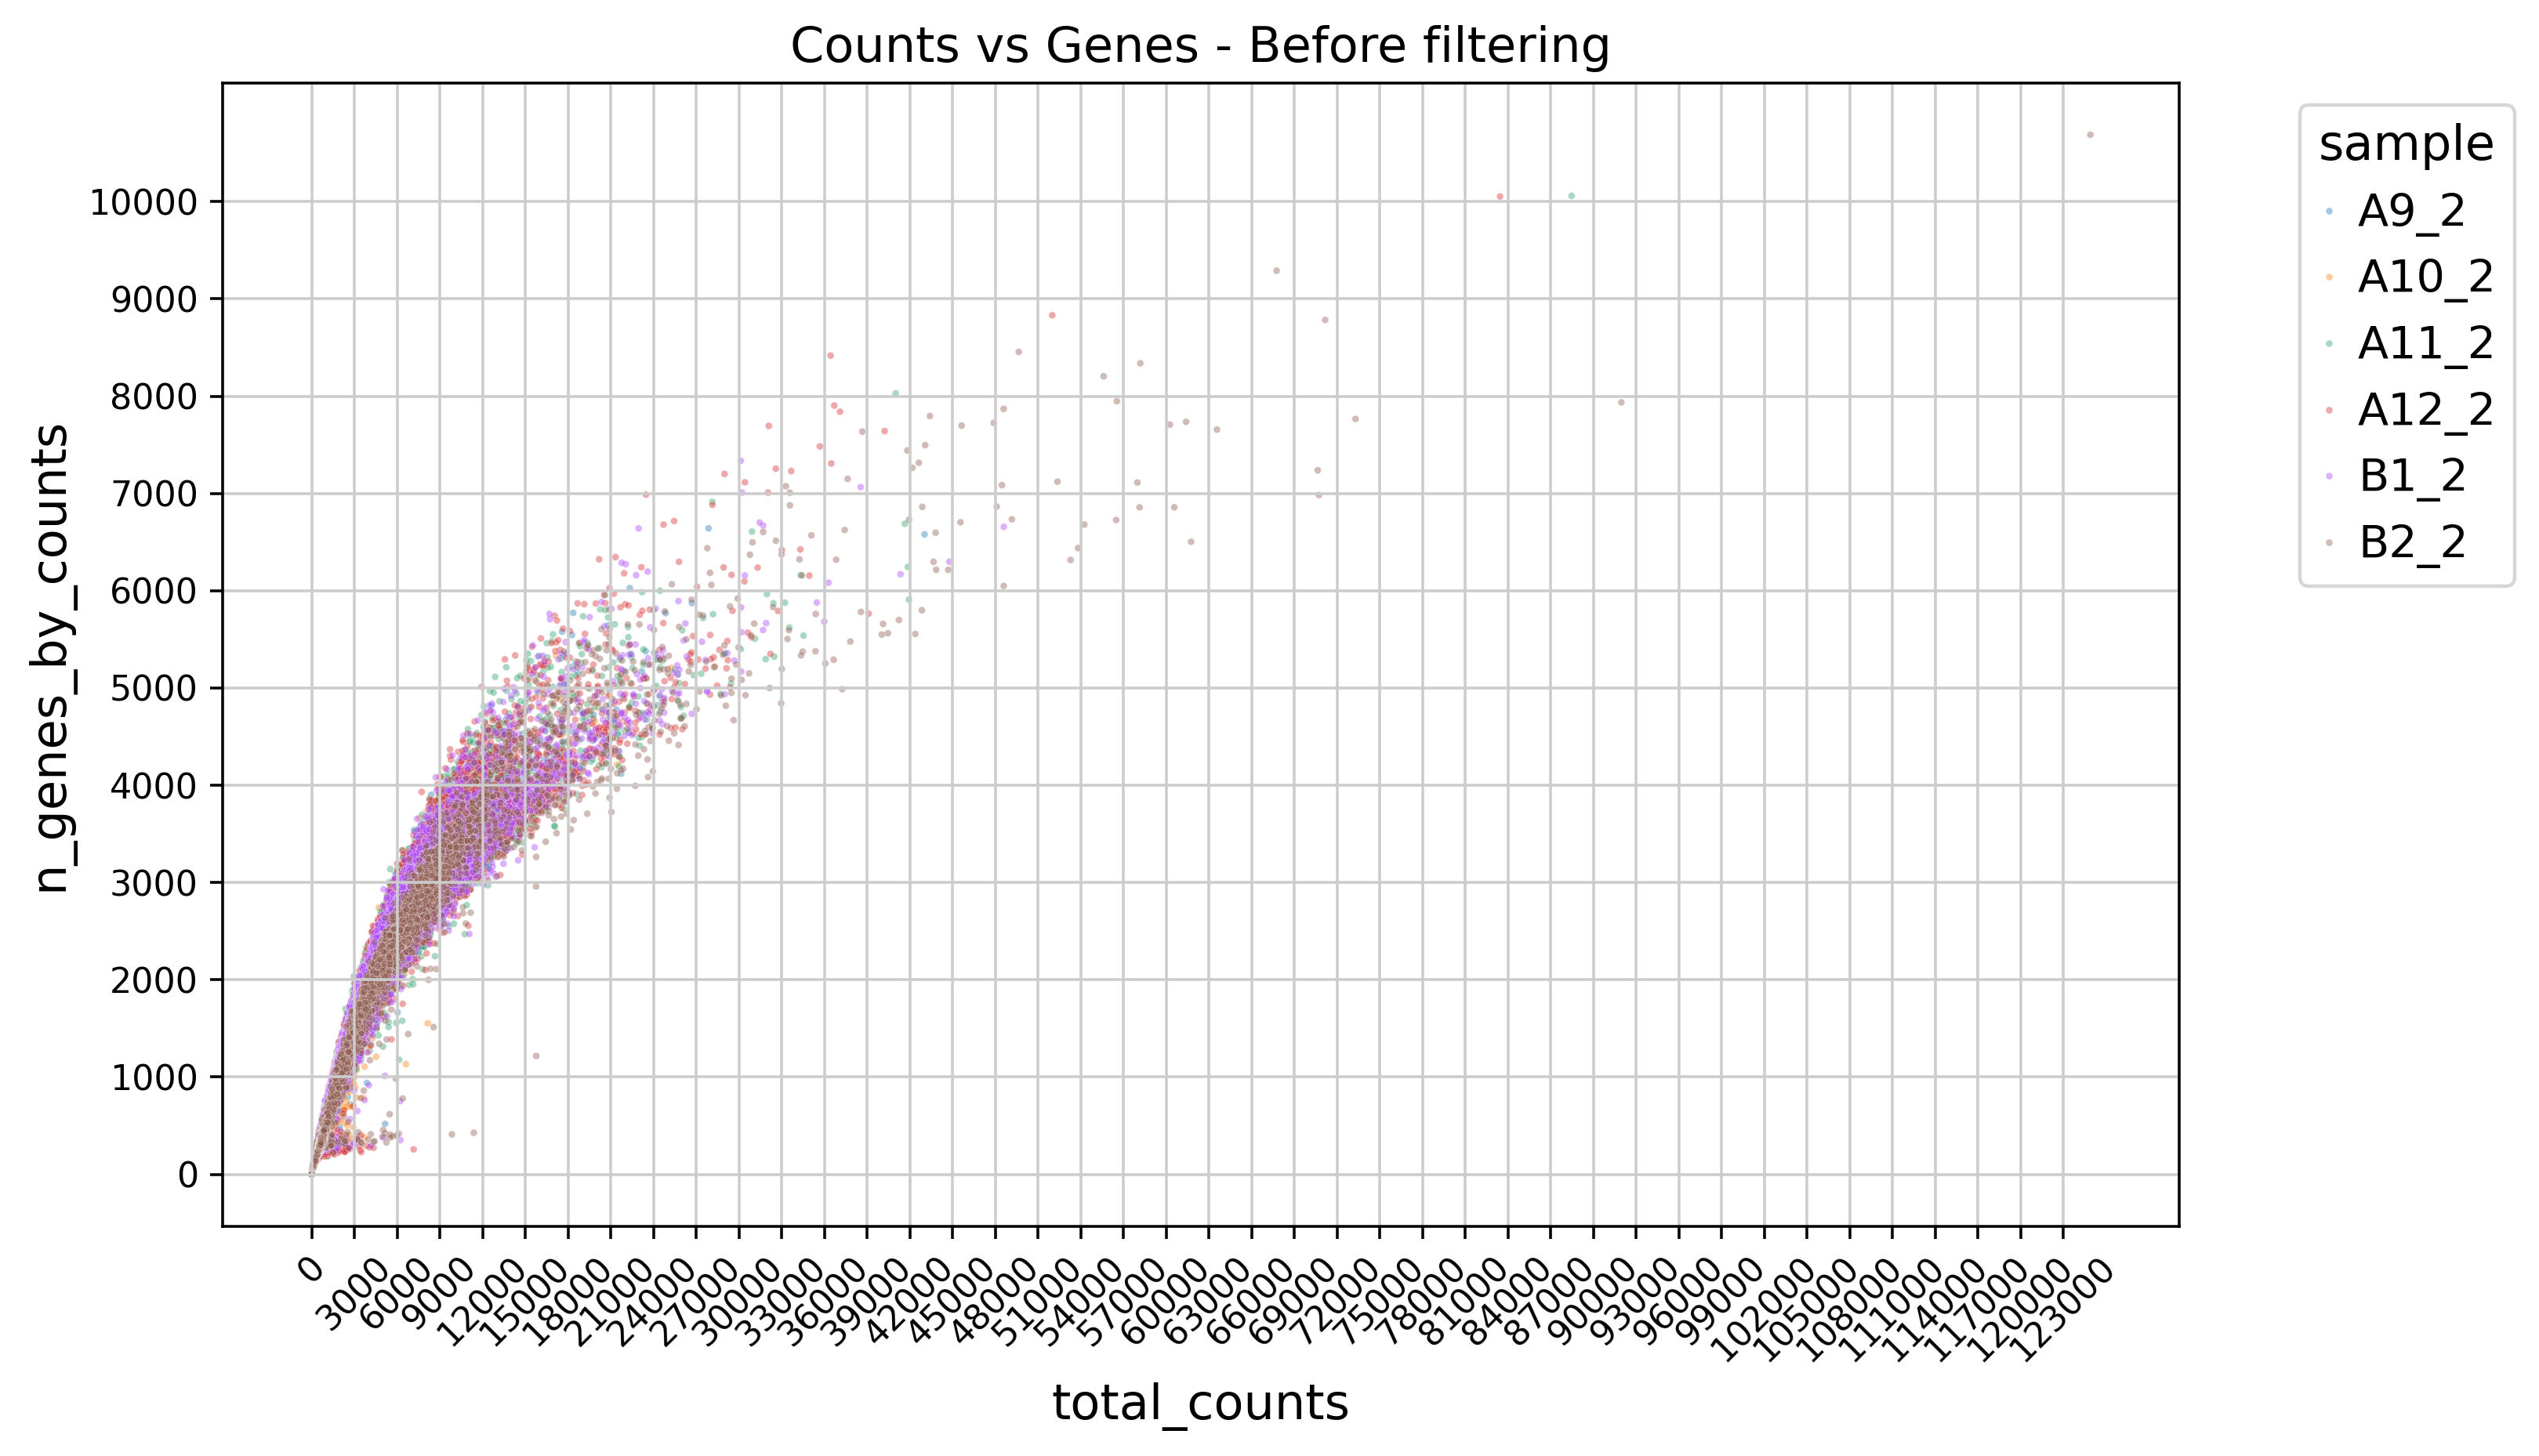

In [12]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=adata.obs, x='total_counts', y='n_genes_by_counts' , hue ='sample', alpha = 0.4, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, int(max(adata.obs['total_counts'])) + 1, 3000),rotation=45, fontsize = 10)
plt.yticks(range(0, int(max(adata.obs['n_genes_by_counts'])) + 1, 1000),fontsize = 10)
plt.title(f'Counts vs Genes - Before filtering')
plt.show()

### Filtering based on QC metrics

In [13]:
filtered_object = adata[adata.obs['n_genes_by_counts'] > 200]
filtered_object = filtered_object[filtered_object.obs['n_genes_by_counts'] < 6000]

filtered_object = filtered_object[filtered_object.obs['total_counts'] > 200]
filtered_object = filtered_object[filtered_object.obs['total_counts'] < 18000]

filtered_object = filtered_object[filtered_object.obs['pct_counts_mt'] < 60]
filtered_object = filtered_object[filtered_object.obs['pct_counts_ribo'] < 20]


filtered_object

View of AnnData object with n_obs × n_vars = 349081 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

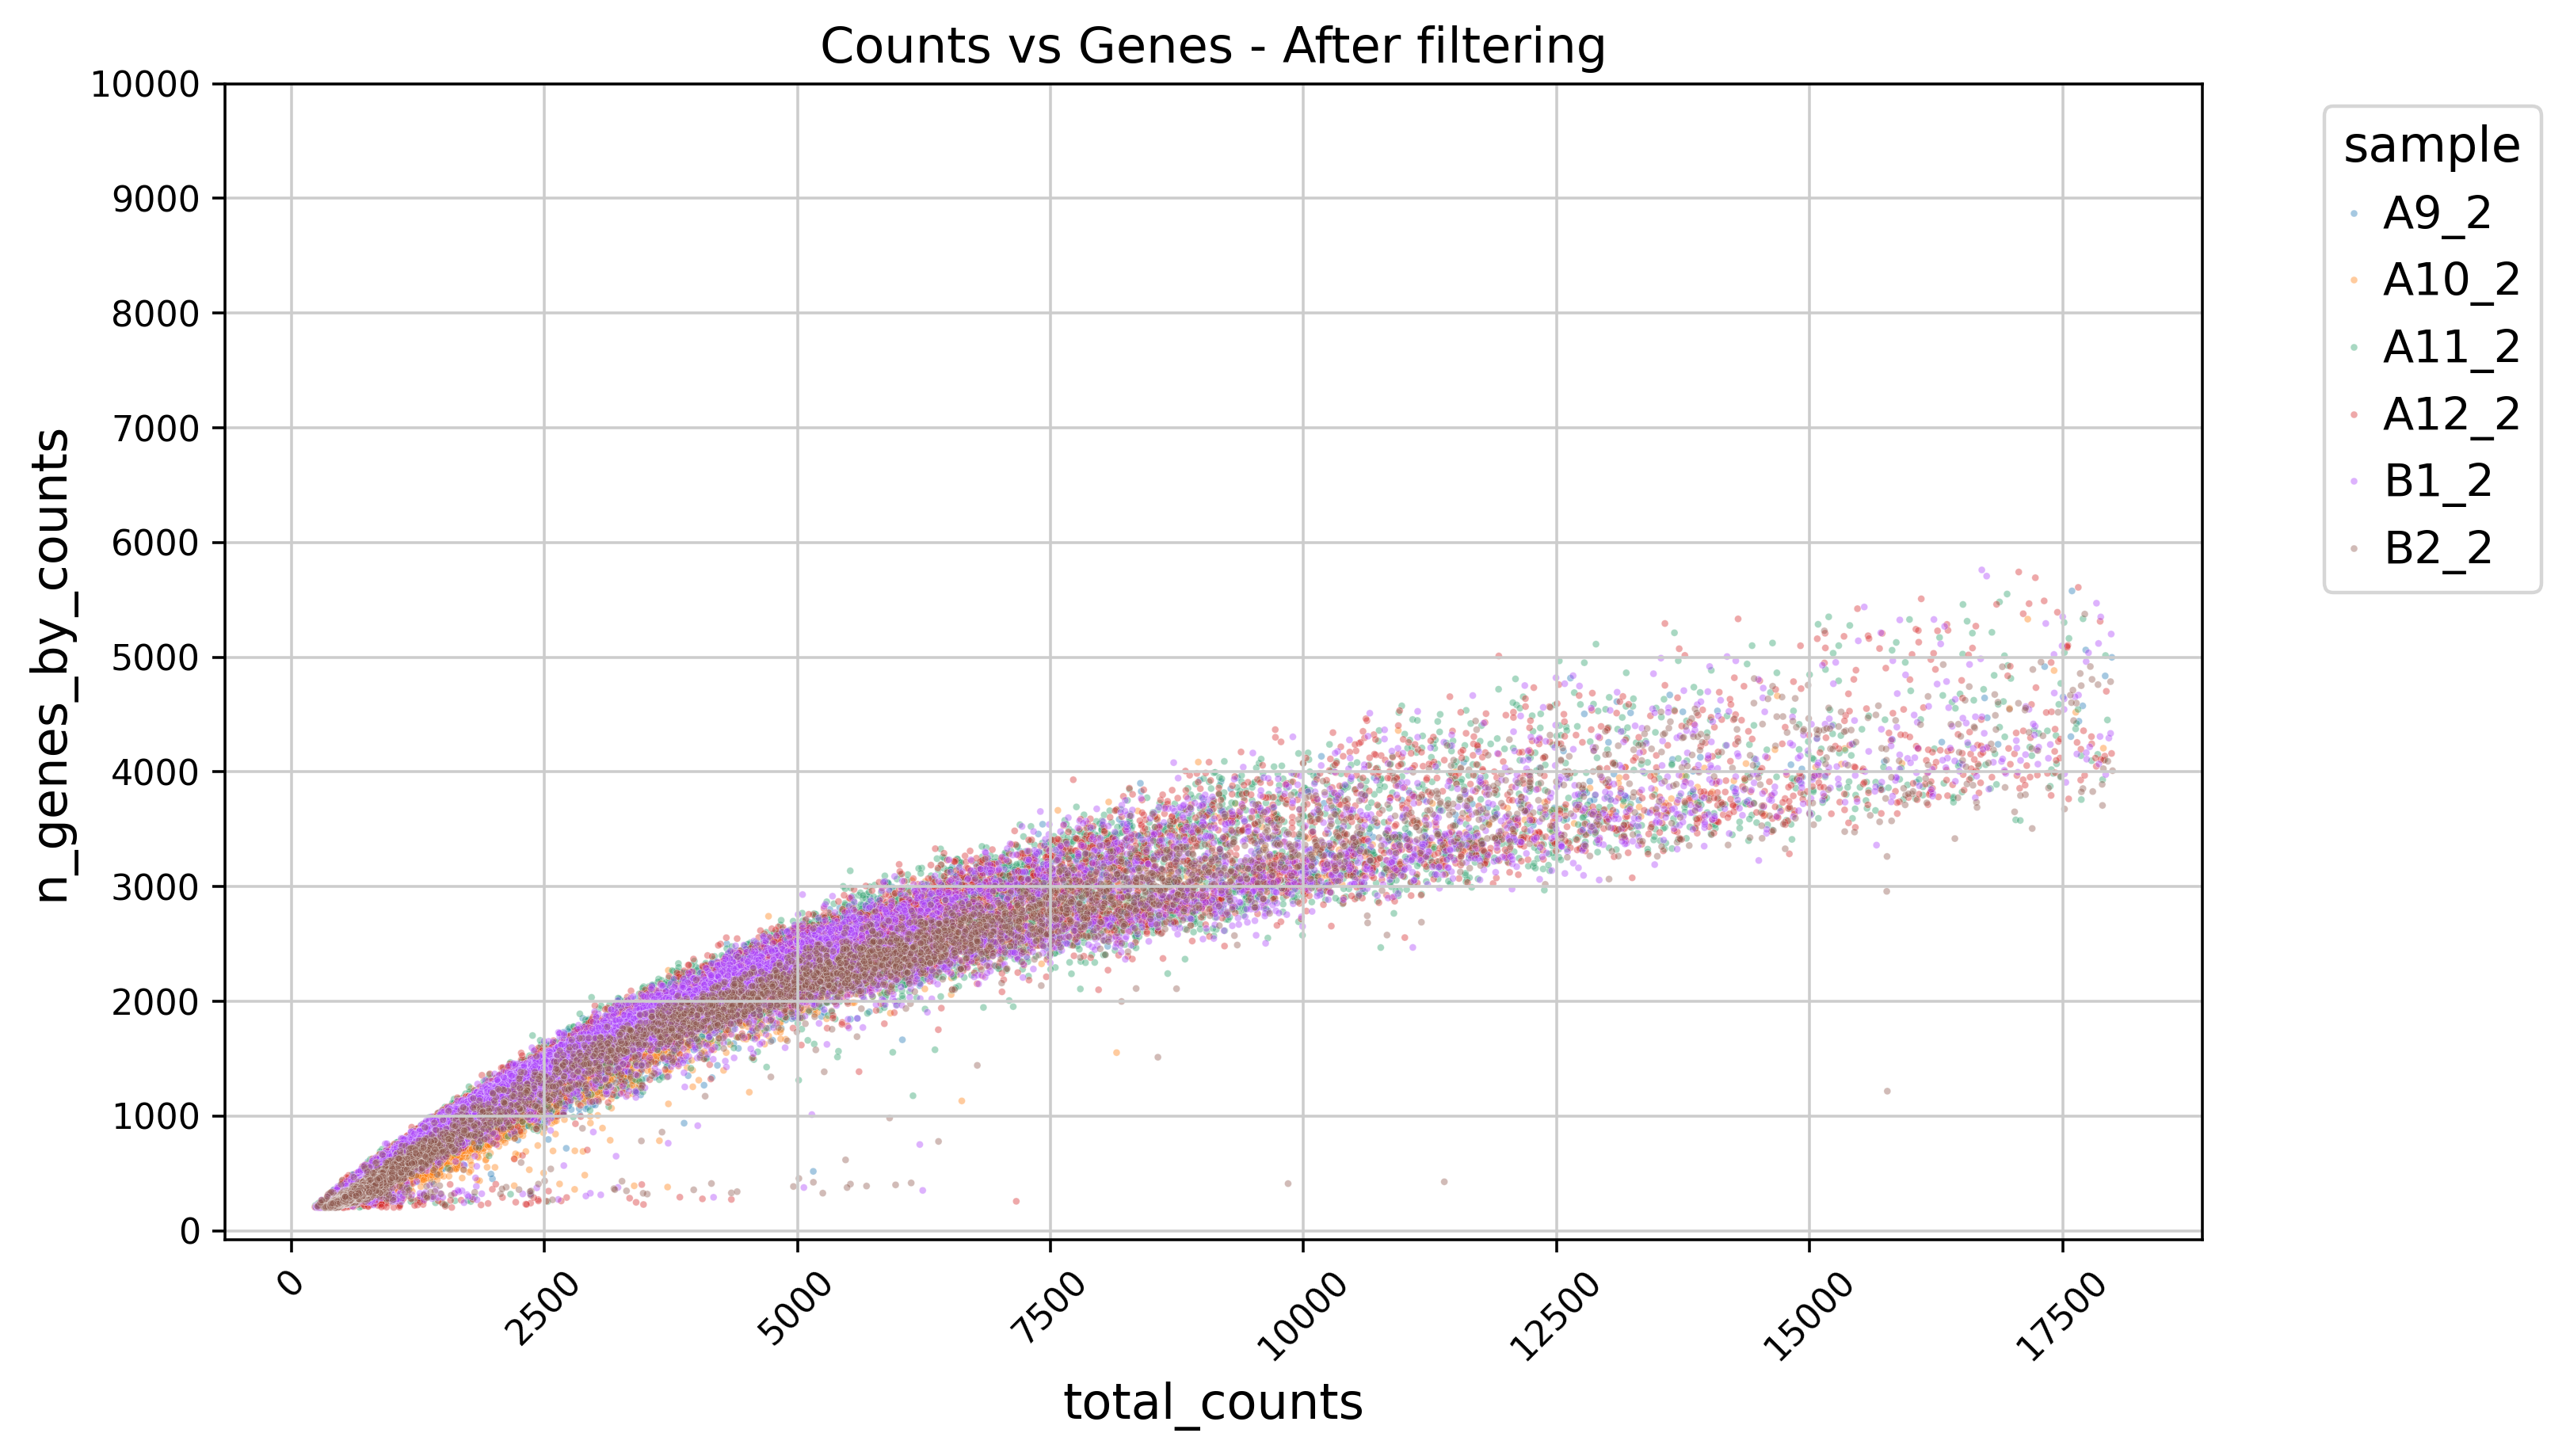

In [14]:
plt.figure(figsize=(10, 6))
sb.scatterplot(data=filtered_object.obs, x='total_counts', y='n_genes_by_counts' , hue ='sample', alpha = 0.4, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, fontsize = 10)
plt.yticks(fontsize = 10)
plt.yticks(range(0, int(max(adata.obs['n_genes_by_counts'])) + 1, 1000),fontsize = 10)
plt.title(f'Counts vs Genes - After filtering')
plt.show()

Text(0.5, 1.0, 'Mt and Ribo percentages - After filtering')

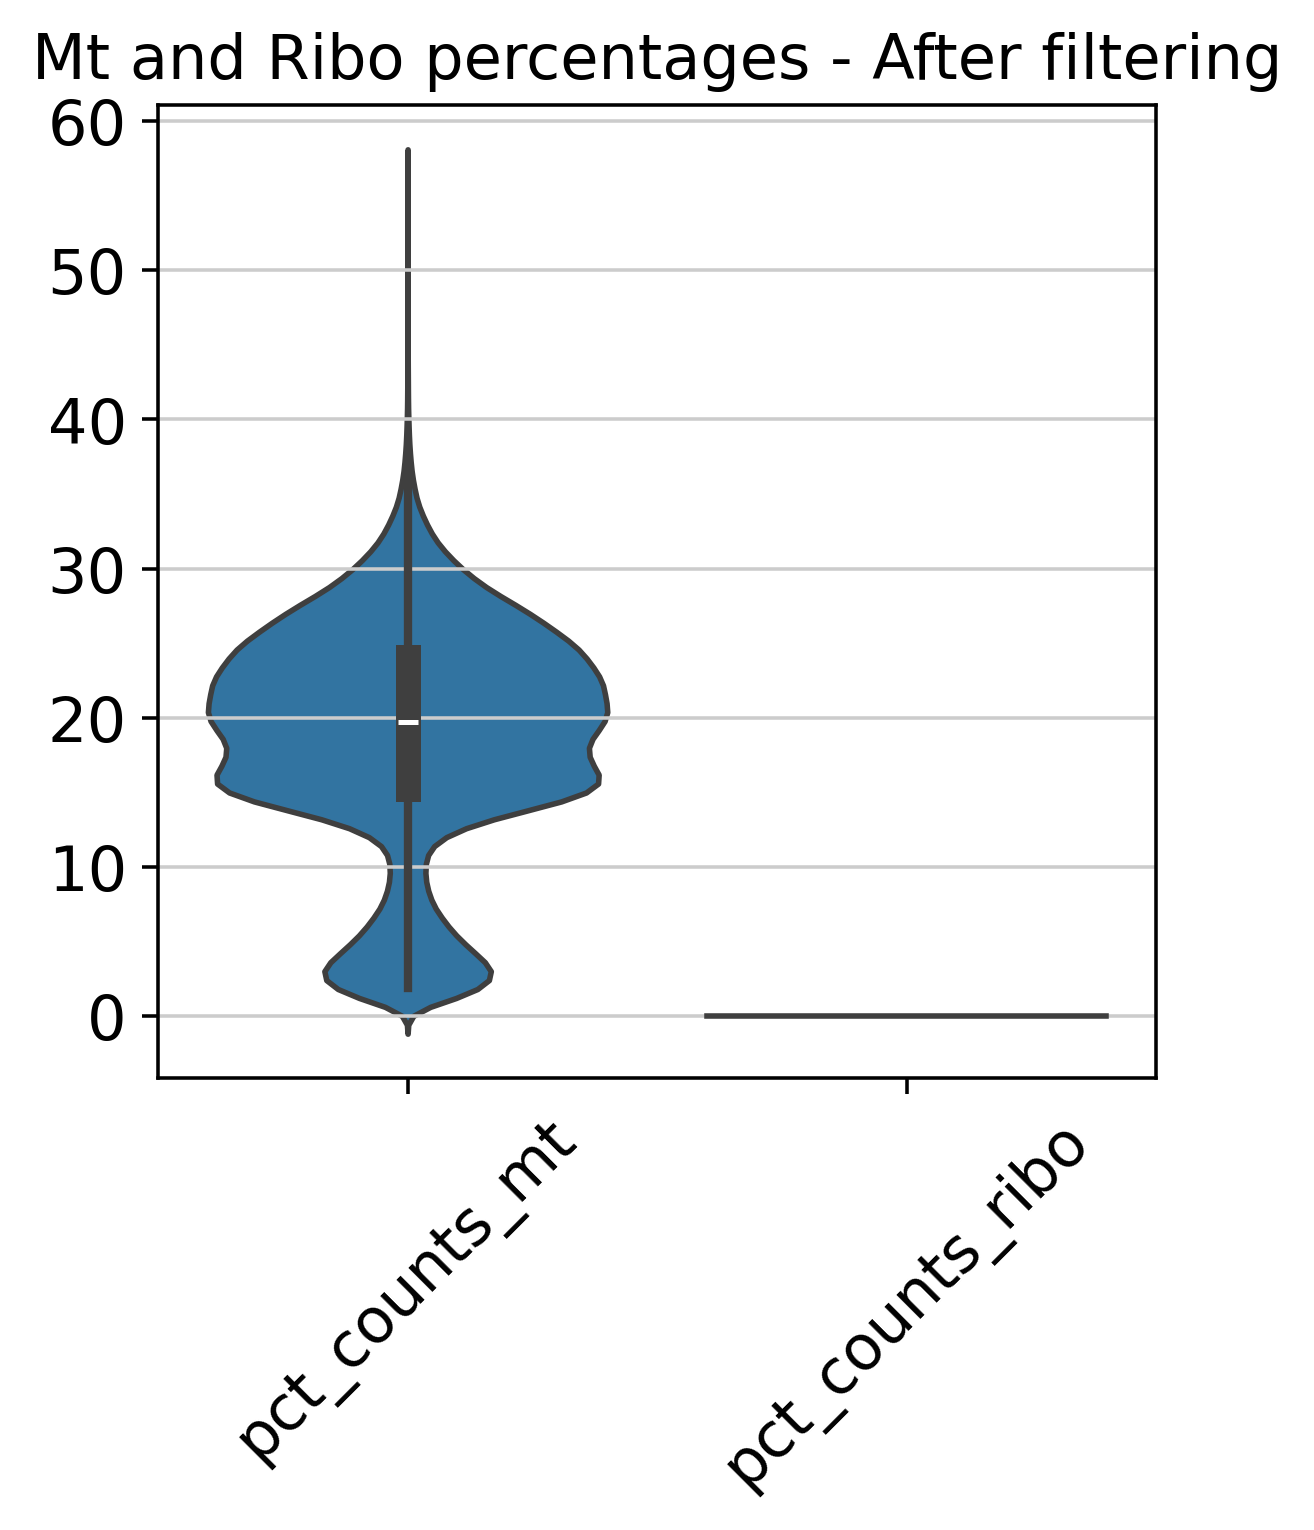

In [15]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sb.violinplot(data=filtered_object.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - After filtering')

## Data normalization

#### Steps followed

1. Creating a copy 
2. Saving counts as a layer without normalization
3. Normalizing cells and squaring them to root to stabilize

In [16]:
filtered_object.raw = filtered_object.copy()

filtered_object.layers['counts'] = filtered_object.X.copy()

filtered_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(filtered_object, inplace = False)["X"]
)

filtered_object

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 349081 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

## Data Export

In [17]:
filtered_object.obs.dtypes

sample               category
genotype             category
n_genes_by_counts       int32
total_counts          float32
total_counts_mt       float32
pct_counts_mt         float32
total_counts_ribo     float32
pct_counts_ribo       float32
dtype: object

In [19]:
filtered_object.write_h5ad(f'../../raw_data/raw_anndatas/dmd_merged_filtered_qc_before_cb_{timestamp}.h5ad')